In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 9999)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [3]:
spark = SparkSession.builder.master("local[2]").appName('car_accidents').getOrCreate()

In [4]:
df = spark.read.csv('C:/Users/a842488/OneDrive - Atos/Desktop/Project', inferSchema='True', header=True)
df = df.sample(0.05)

# Data Analysis

In [5]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doub

In [6]:
df.describe().toPandas().head(10)

,summary,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,count,142755,142755,142755,142755,142755,142755,142755,142755,142755,142755,55192,142755,142755,142749,142755,142755,142675,142755,142567,142263,140212,139312,119337,139123,139809,139266,139044,134797,115397,139270,142594,142594,142594,142594
1,mean,None,2.1369829428041047,None,None,36.25666449096703,-97.08213089129622,36.256825789933835,-97.08188026263885,0.7105555322055281,1125.0,8014.144894187563,None,None,None,None,None,59818.68476374344,None,None,None,None,61.86251076719883,59.720923938091275,64.31846639304788,29.47005557582132,9.09945650769032,None,7.389348427635647,0.007123495411492523,None,None,None,None,None
2,stddev,None,0.4778042698121073,None,None,5.359837978492506,18.322742129908864,5.359949372394222,18.3225942764871,1.6013328772206736,0.0,15592.444925850257,None,None,None,None,None,31585.394838071425,None,None,None,None,18.646140442899675,21.196332744014633,22.869390011471033,1.043363346607635,2.6852954622977254,None,5.351010470400605,0.09286591727229859,None,None,None,None,None
3,min,A-1000008,1,2016-02-10 08:35:27,2016-02-10 14:35:27,24.588812,-124.548074,24.589755,-124.545748,0.0,GRY LEXS OFF RDWY WILL ADV,1.0,1/2 Ave,L,Aaronsburg,Abbeville,AL,01020-5000,US,US/Central,K01M,2016-02-10 08:34:00,-27.9,-53.5,1.0,3.04,0.0,CALM,0.0,0.0,Blowing Dust,Day,Day,Day,Day
4,max,A-999930,4,2021-12-31 22:26:00,2021-12-31 23:41:53,48.993864,-67.86849000000001,49.002140000000004,-67.86838,107.53399999999999,sb near. 1 VEH WAS A DRK COLOREDE VEH POSS A VAN,553507.0,Zumbehl Rd,R,Zwingle,Yuma,WY,99401-9712,US,US/Pacific,KZZV,2021-12-31 23:35:00,170.6,120.0,100.0,31.14,100.0,West,116.0,10.0,Wintry Mix / Windy,Night,Night,Night,Night


In [7]:
df.limit(5).toPandas().head(5)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-51,2,2016-02-10 08:35:27,2016-02-10 14:35:27,41.832,-80.101,41.841,-80.111,0.824,Between Irish Rd and Blystone Rd - Accident.,25529.0,Highway 99,L,Cambridge Springs,Crawford,PA,16403,US,US/Eastern,KGKJ,2016-02-10 08:34:00,21.0,9.9,85.0,29.69,1.0,WSW,10.4,0.00,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,A-60,2,2016-02-10 09:18:13,2016-02-10 15:18:13,39.924,-82.870,39.938,-82.848,1.530,At I-70/US-40/Main St/Exit 43 - Accident.,NaN,Outerbelt N,R,Columbus,Franklin,OH,43232,US,US/Eastern,KCMH,2016-02-10 09:07:00,15.8,3.4,79.0,29.90,1.0,WSW,10.4,0.01,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,A-61,2,2016-02-10 09:34:38,2016-02-10 15:34:38,41.036,-81.570,41.036,-81.580,0.521,At OH-619/Wooster Rd/Exit 17 - Accident.,NaN,I-76 W,R,Akron,Summit,OH,44314,US,US/Eastern,KAKR,2016-02-10 09:46:00,21.0,6.6,74.0,29.79,1.5,WSW,17.3,0.00,Light Snow,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
3,A-65,2,2016-02-10 11:09:08,2016-02-10 17:09:08,38.969,-80.110,39.003,-80.226,6.683,At Talbott Rd - Accident.,NaN,US-33 E,R,Buckhannon,Upshur,WV,26201,US,US/Eastern,KW22,2016-02-10 11:15:00,15.8,NaN,79.0,29.87,6.0,Calm,NaN,NaN,Light Snow,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
4,A-137,2,2016-02-12 10:07:44,2016-02-12 19:07:44,41.468,-81.948,41.469,-81.954,0.358,At Crocker Rd/Exit 156 - Accident.,NaN,Northwest Fwy W,R,Westlake,Cuyahoga,OH,44145,US,US/Eastern,KCLE,2016-02-12 09:51:00,17.1,5.0,65.0,30.17,10.0,SSW,10.4,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [8]:
# add new columns
df = df.withColumn('hour_of_accident', df.Start_Time.substr(12,2)) \
       .withColumn('date_of_accident', df.Start_Time.substr(1,10))

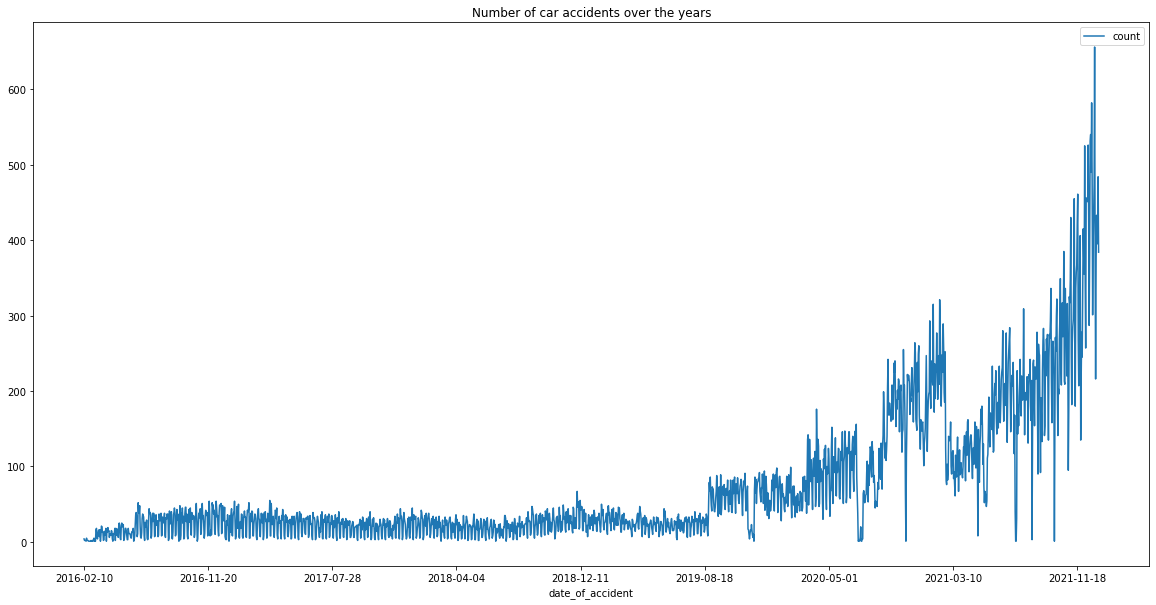

In [9]:
# car accidents over the years
df_date = df.select('date_of_accident').groupBy('date_of_accident').count().orderBy('date_of_accident').toPandas()
df_date_chart = df_date.plot.line(title = 'Number of car accidents over the years', x='date_of_accident', figsize= (20,10))

In [10]:
# create pivot table
distinct_severity = [x.Severity for x in df.select('Severity').distinct().collect()].sort()
df_county= df.groupBy('hour_of_accident').pivot('Severity',distinct_severity).count().orderBy('hour_of_accident')

In [11]:
# pivot the state and hour of accident
df_county = df_county.toPandas().set_index('hour_of_accident')
df_county = df_county.fillna(0)
df_county = df_county.applymap('{:,.0f}'.format)
df_county.head(25)

,1,2,3,4
hour_of_accident,,,,
00,6,"2,975",153,274
01,13,"2,682",107,160
02,14,"2,452",81,169
03,7,"2,081",130,168
04,15,"2,246",115,190
05,26,"3,585",216,267
06,42,"4,910",309,275
07,60,"5,888",434,299
08,66,"5,726",404,292


In [12]:
# top 10 cities with car accidents
# create pivot table
df_city= df.groupBy('City').pivot('Severity',distinct_severity).count()
df_city = df_city.fillna(0) \
                 .withColumn('total', F.col('1') + F.col('2') + F.col('3') + F.col('4')) \
                 .orderBy(F.desc('total')) \
                 .drop('total')

df_city.limit(10).toPandas().set_index('City').head(11)

,1,2,3,4
City,,,,
Miami,2,5187,127,65
Los Angeles,0,3272,114,36
Orlando,23,2673,66,50
Dallas,2,1742,245,58
Houston,0,1574,304,42
Charlotte,20,1580,45,20
Sacramento,25,1567,25,13
San Diego,0,1227,39,21
Raleigh,13,1150,22,13


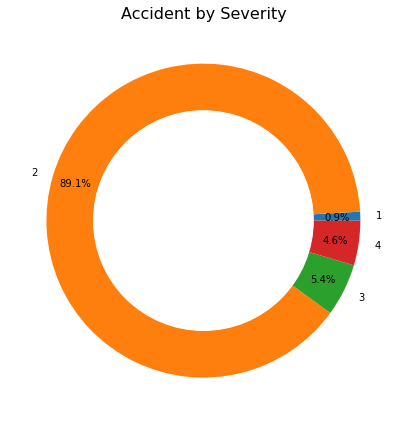

In [13]:
# create visualization of Severity (how many times each category appears in the data set)
df_severity = df.select('ID','Severity').toPandas().groupby('Severity').count()['ID']

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))
label = [1,2,3,4]
plt.pie(df_severity, labels=label,
        autopct='%1.1f%%', pctdistance=0.85)
circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
ax.set_title("Accident by Severity",fontdict={'fontsize': 16})
plt.tight_layout()
plt.show()

In [14]:
# create list of numerical and categorical columns 
numerical_cols = df.columns[21:29]
categorical_cols = df.columns[29:47]

In [15]:
# create blank df 
blank_df = spark.range(0).drop("id")
blank_df = blank_df.withColumn('working', F.lit(None).cast(StringType())) \
                   .withColumn('1', F.lit(None).cast(IntegerType())) \
                   .withColumn('2', F.lit(None).cast(IntegerType())) \
                   .withColumn('3', F.lit(None).cast(IntegerType())) \
                   .withColumn('4', F.lit(None).cast(IntegerType())) 


In [16]:
# use blank_df as container for pivoted tables with the view Severity - conditions
for temp in categorical_cols:
    temp_df = df.groupBy(temp).pivot('Severity',distinct_severity).count()
    temp_df = temp_df.withColumn('name', F.lit(temp))
    temp_df = temp_df.withColumn(temp,F.concat(F.col('name'), F.lit(": "), F.col(temp))) \
                     .drop('name') \
                     .withColumnRenamed(temp, 'working')
    blank_df = blank_df.unionAll(temp_df) 

blank_df = blank_df.withColumnRenamed('working', 'Conditions / Severity') \
                   .fillna(0) \
                   .toPandas()

blank_df.head(100)

,Conditions / Severity,1,2,3,4
0,Weather_Condition: Ice Pellets,0,0,0,1
1,Weather_Condition: Shallow Fog,0,48,3,4
2,Weather_Condition: Thunderstorm,0,31,7,4
3,Weather_Condition: Light Snow with Thunder,0,0,1,0
4,Weather_Condition: Light Sleet,0,2,0,0
5,Weather_Condition: Light Snow / Windy,0,95,5,3
6,Weather_Condition: Volcanic Ash,0,1,0,0
7,Weather_Condition: N/A Precipitation,0,50,0,2
8,Weather_Condition: Freezing Rain / Windy,0,1,0,0
9,Weather_Condition: Showers in the Vicinity,0,27,0,0


In [17]:
# lets drop na
df_test = df.na.drop('any')

for i in categorical_cols:
    df_test = df_test.withColumn(i,F.col(i).cast(StringType()))
    
# drop wind direction col
df_test = df_test.drop('Wind_Direction')
numerical_cols.remove('Wind_Direction')

In [18]:
# use OneHotEncoder to convert categorical columns into vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

list_of_cols = categorical_cols

stringIndexer = [StringIndexer(inputCol=i, outputCol=i + "_index").fit(df_test) for i in list_of_cols]

encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="job_vec_"+indexer.getOutputCol()) for indexer in stringIndexer]

list_of_encoders = [encoder.getOutputCol() for encoder in encoders]
list_of_encoders = numerical_cols + list_of_encoders 

vector_assembler = VectorAssembler(inputCols=list_of_encoders, outputCol="features")

pipeline = Pipeline(stages = stringIndexer + encoders + [vector_assembler])
model = pipeline.fit(df_test)
df = model.transform(df_test)

In [33]:
# create feature importance
from itertools import chain

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*va_df
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))

feature_importance = [(name, gbtr.featureImportances[idx])
 for idx, name in attrs
 if gbtr.featureImportances[idx]]

In [44]:
names = [feature_importance[i][0] for i in range(len(feature_importance))]
values = [round(feature_importance[i][1],3) for i in range(len(feature_importance))]

for i in range(len(names)):
    print(f'{names[i]} : {values[i]}')

Temperature(F) : 0.132
Wind_Chill(F) : 0.035
Humidity(%) : 0.133
Pressure(in) : 0.187
Visibility(mi) : 0.065
Wind_Speed(mph) : 0.114
Precipitation(in) : 0.035
job_vec_Weather_Condition_index_Fair : 0.01
job_vec_Weather_Condition_index_Cloudy : 0.015
job_vec_Weather_Condition_index_Mostly Cloudy : 0.005
job_vec_Weather_Condition_index_Partly Cloudy : 0.021
job_vec_Weather_Condition_index_Light Rain : 0.01
job_vec_Weather_Condition_index_Fog : 0.007
job_vec_Weather_Condition_index_Haze : 0.002
job_vec_Weather_Condition_index_Light Snow : 0.01
job_vec_Weather_Condition_index_Rain : 0.005
job_vec_Weather_Condition_index_Fair / Windy : 0.003
job_vec_Weather_Condition_index_Thunder in the Vicinity : 0.001
job_vec_Weather_Condition_index_Thunder : 0.003
job_vec_Weather_Condition_index_Heavy Rain : 0.005
job_vec_Weather_Condition_index_Smoke : 0.003
job_vec_Weather_Condition_index_T-Storm : 0.0
job_vec_Weather_Condition_index_Cloudy / Windy : 0.003
job_vec_Weather_Condition_index_Mostly Cloudy

# Create the model - GBT Regression

In [19]:
# create model and split the data
from pyspark.ml.regression import GBTRegressor

va_df = df.select(['features','Severity'])
(train, test) = va_df.randomSplit([0.8, 0.2], seed=123)

gbtr = GBTRegressor(featuresCol='features', labelCol='Severity', maxIter=100)
gbtr = gbtr.fit(train)

In [20]:
# test our model and print indexes
mdata = gbtr.transform(test)
mdata.show(3)
 
rmse=RegressionEvaluator(labelCol="Severity", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(mdata) 
 
mae=RegressionEvaluator(labelCol="Severity", predictionCol="prediction", metricName="mae")
mae=mae.evaluate(mdata) 
 
r2=RegressionEvaluator(labelCol="Severity", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(mdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

+--------------------+--------+------------------+
|            features|Severity|        prediction|
+--------------------+--------+------------------+
|(99,[0,1,2,3,4,5,...|       2|2.1644173606162775|
|(99,[0,1,2,3,4,5,...|       2| 2.011927144931449|
|(99,[0,1,2,3,4,5,...|       4|2.1584568611653125|
+--------------------+--------+------------------+
only showing top 3 rows

RMSE:  0.3638576613774096
MAE:  0.13958579773639185
R-squared:  0.022239652578452396


In [21]:
# add new columns that will check if prediction is correct after rounding up the value
mdata = mdata.withColumn('prediction',F.round(F.col('prediction'),0)) \
             .withColumn('check', F.when(F.col('Severity') == F.col('prediction'), 1).otherwise(0))

In [22]:
# create table with % of predicted values
final_view = mdata.select('check').groupBy('check').count() \
                  .withColumn('check', 
                              F.when(F.col('check') == 1, F.regexp_replace(F.col('check'), '1', 'Predicted correctly'))
                              .otherwise('Predicted incorrectly'))

final_view = final_view.withColumn('ratio', F.col('count')/final_view.groupBy().sum().collect()[0][0]) \
                       .toPandas()
final_view.head()

,check,count,ratio
0,Predicted correctly,8879,0.945
1,Predicted incorrectly,518,0.055


<Figure size 12000x8000 with 0 Axes>

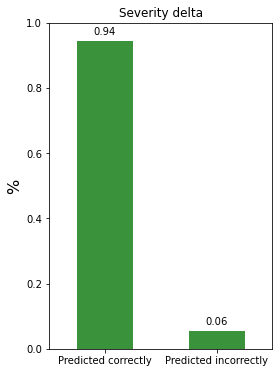

In [23]:
# visualize the data
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.pyplot.figure(dpi=2000) #improve the quality
plt.figure(figsize=(4, 6))
plt.title('Severity delta')
splot=sns.barplot(x="check", y="ratio", color = 'tab:green', data=final_view)
splot.set(xlabel=None)  # remove the axis label
plt.ylim([0, 1])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel("%", size=16)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(splot, .5)